In [2]:
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Subset
import torchvision
import torchvision.transforms as transforms

from net.AutoEncoder import AutoEncoder
from dataloader.cifar import CustomCifar
from dataloader.dataset import CustomDataset

%matplotlib inline

In [ ]:
EPOCHS = 100
LR = 2e-3
BATCH_SIZE = 10


In [1]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# cifar10 = CustomCifar()
# cifar10.get_full_dataset()

# trainset = CustomDataset(cifar10.data, cifar10.targets, transform=transform)
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)


iter_losses = []
epoch_losses = []

net = AutoEncoder()
loss_function = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)

save_dir = f'./ckpt/SGD_{LR}_MSE_batch{BATCH_SIZE}_{EPOCHS}epoch/'

os.makedirs(save_dir, exist_ok=True)

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print("Training Start")
for epoch in range(EPOCHS):
  start = time.time()
  for image, _ in trainloader:
    image = image.reshape(-1, 3 * 32 * 32)

    image.to(DEVICE)

    reconstructed = net(image)

    loss = loss_function(reconstructed, image)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    iter_losses.append(loss.item())

  epoch_losses.append(loss.item())
  duration = time.time() - start
  print(f"Epoch {epoch + 1}  Loss:{loss.item()} {round(duration,2)}sec")
  if epoch % 10 == 0:
    torch.save(net.state_dict(),
               save_dir + f'model_{epoch // 10}.pth'
               )

    loss_dict = {'iter_loss': iter_losses,'epoch_loss': epoch_losses}
    with open(save_dir + 'loss.json', 'w') as f:
      json.dump(loss_dict, f)


Files already downloaded and verified
Files already downloaded and verified
Training Start
Epoch 1  Loss:0.19341260194778442 62.07779574394226 sec
Epoch 2  Loss:0.24560460448265076 63.22677230834961 sec
Epoch 3  Loss:0.2187345176935196 62.785807847976685 sec
Epoch 4  Loss:0.20862294733524323 62.21060013771057 sec
Epoch 5  Loss:0.23071101307868958 62.17970538139343 sec
Epoch 6  Loss:0.18029704689979553 61.67975330352783 sec
Epoch 7  Loss:0.2779805064201355 62.01857089996338 sec
Epoch 8  Loss:0.20219603180885315 63.21347665786743 sec
Epoch 9  Loss:0.26968619227409363 62.458977699279785 sec
Epoch 10  Loss:0.21476934850215912 62.72200393676758 sec


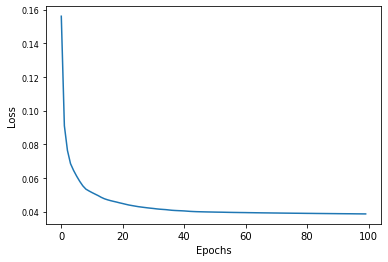

In [3]:
with open('./ckpt/SGD_0.2_MSE_batch50_100epoch_unbalanced/loss.json') as f:
  losses = json.loads(f.read())

plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)

# plt.xticks(range(0, 500000, 50000),fontsize=8)
plt.yticks(fontsize=8)

plt.plot(losses['loss'])
